In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np

print("TensorFlow version is: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version is: {}".format(tf.keras.__version__))

TensorFlow version is: 2.8.0
Eager execution is: True
Keras version is: 2.8.0


# load data

In [3]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [4]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [5]:
labels = read_labels('coco.txt')
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [6]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# keras custom layer experiment

In [332]:
class NMSLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(NMSLayer, self).__init__(**kwargs)
#         super(NMSLayer, self).__init__(name=name)
        
    def get_config(self):
        config = super(NMSLayer, self).get_config()
        return config
        
    def call(self, inputs):
        print(type(inputs))
        print(f'-------- {inputs[0]}')
        print(f'-------- {inputs[1]}')
        
        boxes = inputs[0]
        scores = inputs[1]
        return tf.image.non_max_suppression(
            boxes,
            scores,
            10,
            iou_threshold=0.4,
            score_threshold=float(.25),
            name='nms'
        )

# keras and tensorflow experiments

In [113]:

from tensorflow.keras.layers import Lambda
from tensorflow import slice


In [129]:
num_pred = 2
num_classes = 80
total_len = 4 + num_classes
test_arr = np.arange(num_pred * total_len).reshape(1, num_pred, total_len)
test_arr

array([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
          24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
          36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
          48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
          60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
          72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
        [ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
          96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
         108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
         120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
         132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
         144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167]]])

In [130]:
test_arr[..., 1]

array([[ 1, 85]])

In [131]:
tf.keras.layers.Lambda(lambda x: x[..., 4:])(test_arr)

<tf.Tensor: shape=(1, 2, 80), dtype=int64, numpy=
array([[[  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
          16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
          40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
          64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
          76,  77,  78,  79,  80,  81,  82,  83],
        [ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
         100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
         124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
         136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
         148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
         160, 161, 162, 163, 164, 165, 166, 167]]])>

In [333]:
inputs = tf.keras.layers.Input(shape=(None, total_len), name='model_input')
slice_y0 = tf.keras.layers.Lambda(lambda x: x[..., 1], name = 'all_y0')(inputs)
slice_y1 = tf.keras.layers.Lambda(lambda x: x[..., 3], name = 'all_y1')(inputs)

slice_x0 = tf.keras.layers.Lambda( lambda x: x[..., 0], name = 'all_x0')(inputs)
slice_x1 = tf.keras.layers.Lambda( lambda x: x[..., 2], name = 'all_x1')(inputs)

slice_height = tf.keras.layers.Subtract()([slice_y1, slice_y0])
slice_width = tf.keras.layers.Subtract()([slice_x1, slice_x0])

concatenate_x0_y0 = tf.keras.layers.Concatenate(axis = 0, name='concatenate_x0_y0')([slice_x0,slice_y0, slice_height, slice_width])
transpose_dims = tf.keras.layers.Lambda(lambda x: tf.transpose(x), name ='all_boxes')(concatenate_x0_y0)

slice_confidences = tf.keras.layers.Lambda(lambda x: x[..., 4:], name = 'all_scores')(inputs)




class_ids = tf.keras.layers.Lambda(lambda x: tf.argmax(x, axis = 2), name='class_ids')(slice_confidences)
reshaped_class_ids = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=0), name = 'reshaped_confidences')(class_ids)

scores = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis = 2), name='scores')(slice_confidences)
# tf.keras.layers.Lambda(lambda x: tf.argmax(x, axis = 2), name='scores')(slice_confidences)
reshaped_sores = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=0), name = 'reshaped_sores')(scores)

concatenate_y1_x1_y2_x2 = tf.keras.layers.Concatenate(
    axis = 0, 
    name='concatenate_y1_x1_y2_x2')([slice_y0,slice_x0, slice_y1, slice_x1])
transpose_concatenate_y1_x1_y
2_x2 = tf.keras.layers.Lambda(lambda x: tf.transpose(x), name ='all_boxes_nms')(concatenate_y1_x1_y2_x2)

nms_output = NMSLayer(name ='nms_output')([transpose_concatenate_y1_x1_y2_x2, reshaped_sores])

decoder_model = tf.keras.Model(inputs = [inputs], outputs = [transpose_dims, reshaped_class_ids, reshaped_sores, nms_output], name = 'yolo_decoder')

<class 'list'>
-------- Tensor("Placeholder:0", shape=(None, None), dtype=float32)
-------- Tensor("Placeholder_1:0", shape=(None,), dtype=float32)


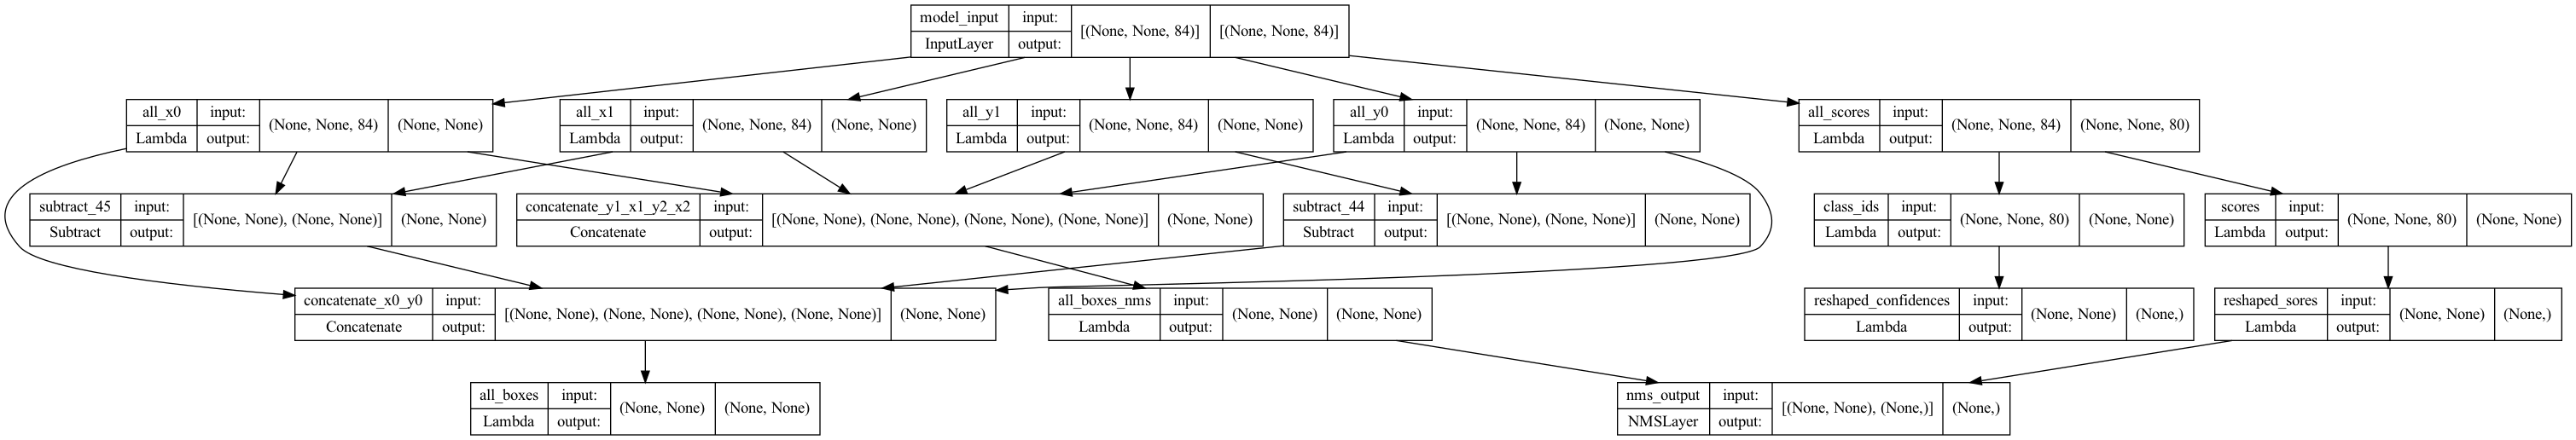

In [301]:
tf.keras.utils.plot_model(decoder_model, "decoder_model.png", show_shapes=True)

In [134]:
decoder_model.summary()

Model: "yolo_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model_input (InputLayer)       [(None, None, 84)]   0           []                               
                                                                                                  
 all_x0 (Lambda)                (None, None)         0           ['model_input[0][0]']            
                                                                                                  
 all_y0 (Lambda)                (None, None)         0           ['model_input[0][0]']            
                                                                                                  
 all_y1 (Lambda)                (None, None)         0           ['model_input[0][0]']            
                                                                                       

In [135]:
decoder_model.predict(test_arr)

<class 'list'>
-------- Tensor("yolo_decoder/all_boxes/transpose:0", shape=(2, None), dtype=float32)
-------- Tensor("yolo_decoder/reshaped_sores/Squeeze:0", shape=(2,), dtype=float32)


[array([[ 0.,  1.,  2.,  2.],
        [84., 85.,  2.,  2.]], dtype=float32),
 array([79, 79]),
 array([ 83., 167.], dtype=float32),
 array([1, 0], dtype=int32)]

In [136]:
test_arr

array([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
          24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
          36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
          48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
          60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
          72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
        [ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
          96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
         108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
         120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
         132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
         144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167]]])

In [137]:
decoder_model.outputs

[<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'all_boxes')>,
 <KerasTensor: shape=(None,) dtype=int64 (created by layer 'reshaped_confidences')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'reshaped_sores')>,
 <KerasTensor: shape=(None,) dtype=int32 (created by layer 'nms_layer_49')>]

In [138]:
type(decoder_model)

keras.engine.functional.Functional

# Experiments Sequential model

In [140]:
yolo_tiny_model = load_model('yolov4-tiny-608-1stJun')

In [141]:
type(yolo_tiny_model)

keras.engine.functional.Functional

In [142]:
yolo_tiny_model.input.shape

TensorShape([None, 608, 608, 3])

In [143]:
yolo_tiny_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 609, 609, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 304, 304, 32  864         ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 tf_op_layer_LeakyRelu_6 (Tenso  (None, 76, 76, 128)  0          ['batch_normalization_6[0][0]']  
 rFlowOpLayer)                                                                                    
                                                                                                  
 tf_op_layer_split_1 (TensorFlo  [(None, 76, 76, 64)  0          ['tf_op_layer_LeakyRelu_6[0][0]']
 wOpLayer)                      , (None, 76, 76, 64                                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 76, 76, 64)   36864       ['tf_op_layer_split_1[0][1]']    
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 76, 76, 64)  256         ['conv2d_7[0][0]']               
 rmalizati

                                                                 ']                               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 19, 19, 512)  0          ['tf_op_layer_concat_5[0][0]']   
                                                                                                  
 conv2d_14 (Conv2D)             (None, 19, 19, 512)  2359296     ['max_pooling2d_2[0][0]']        
                                                                                                  
 batch_normalization_14 (BatchN  (None, 19, 19, 512)  2048       ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf_op_layer_LeakyRelu_14 (Tens  (None, 19, 19, 512)  0          ['batch_normalization_14[0][0]'] 
 orFlowOpL

 tf_op_layer_Reshape_3 (TensorF  (None, 19, 19, 3, 8  0          ['conv2d_17[0][0]',              
 lowOpLayer)                    5)                                'tf_op_layer_Reshape_3/shape[0][
                                                                 0]']                             
                                                                                                  
 tf_op_layer_split_3 (TensorFlo  [(None, 38, 38, 3,   0          ['tf_op_layer_Reshape[0][0]']    
 wOpLayer)                      2),                                                               
                                 (None, 38, 38, 3,                                                
                                2),                                                               
                                 (None, 38, 38, 3,                                                
                                1),                                                               
          

 owOpLayer)                     )                                 'tf_op_layer_Mul_2[0][0]']      
                                                                                                  
 tf_op_layer_Reshape_2/shape (T  (3,)                0           ['tf_op_layer_strided_slice[0][0]
 ensorFlowOpLayer)                                               ']                               
                                                                                                  
 tf_op_layer_concat_8 (TensorFl  (None, 19, 19, 3, 4  0          ['tf_op_layer_Mul_5[0][0]',      
 owOpLayer)                     )                                 'tf_op_layer_Mul_6[0][0]']      
                                                                                                  
 tf_op_layer_Reshape_5/shape (T  (3,)                0           ['tf_op_layer_strided_slice_1[0][
 ensorFlowOpLayer)                                               0]']                             
          

                                                                                                  
 tf_op_layer_strided_slice_4 (T  (1,)                0           ['tf_op_layer_Shape_4[0][0]']    
 ensorFlowOpLayer)                                                                                
                                                                                                  
 tf_op_layer_Reshape_7 (TensorF  (None,)             0           ['tf_op_layer_GreaterEqual[0][0]'
 lowOpLayer)                                                     ]                                
                                                                                                  
 tf_op_layer_concat_11 (TensorF  (2,)                0           ['tf_op_layer_strided_slice_3[0][
 lowOpLayer)                                                     0]',                             
                                                                  'tf_op_layer_concat_11/values_1[
          

                                                                                                  
 tf_op_layer_Where_1 (TensorFlo  (None, 1)           0           ['tf_op_layer_Reshape_9[0][0]']  
 wOpLayer)                                                                                        
                                                                                                  
 tf_op_layer_strided_slice_13 (  (None, None, 2)     0           ['tf_op_layer_split_5[0][1]']    
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_Reshape_8 (TensorF  (None, 80)          0           ['tf_op_layer_concat_10[0][0]',  
 lowOpLayer)                                                      'tf_op_layer_concat_12[0][0]']  
                                                                                                  
 tf_op_lay

                                                                                                  
 tf_op_layer_Reshape_12 (Tensor  (1, None, 84)       0           ['tf_op_layer_concat_14[0][0]']  
 FlowOpLayer)                                                                                     
                                                                                                  
Total params: 6,062,814
Trainable params: 6,056,606
Non-trainable params: 6,208
__________________________________________________________________________________________________


In [144]:
yolo_tiny_model.inputs

[<KerasTensor: shape=(None, 608, 608, 3) dtype=float32 (created by layer 'input_1')>]

In [145]:
yolo_tiny_model.outputs

[<KerasTensor: shape=(1, None, 84) dtype=float32 (created by layer 'tf_op_layer_Reshape_12')>]

In [334]:
x = yolo_tiny_model.outputs[0]
x.shape

TensorShape([1, None, 84])

In [335]:
decoder_model.input.shape

TensorShape([None, None, 84])

In [336]:
inputs = tf.keras.layers.Input(shape=(608, 608, 3))
x = yolo_tiny_model(inputs)


In [337]:
predictions = decoder_model(x)

<class 'list'>
-------- Tensor("yolo_decoder/all_boxes_nms/transpose:0", shape=(None, 4), dtype=float32)
-------- Tensor("yolo_decoder/reshaped_sores/Squeeze:0", shape=(None,), dtype=float32)


In [338]:
combined_model = tf.keras.Model(inputs=inputs, outputs=predictions)

In [339]:
combined_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 608, 608, 3)]     0         
                                                                 
 model (Functional)          (1, None, 84)             6062814   
                                                                 
 yolo_decoder (Functional)   [(None, None),            0         
                              (None,),                           
                              (None,),                           
                              (None,)]                           
                                                                 
Total params: 6,062,814
Trainable params: 6,056,606
Non-trainable params: 6,208
_________________________________________________________________


In [340]:
combined_model.save('decoded_yolo.h5')

# prediction

In [254]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def draw_preds_bbs(file_name, preds_pipeline, is_coreml = False):
    print(preds_pipeline[0].shape)
    print(preds_pipeline[1].shape)
    boxes = preds_pipeline[0]
    class_ids = preds_pipeline[1]
    scores = preds_pipeline[2]
    nms_ids = preds_pipeline[3]

    print('start drawing boxes')
    data = pyplot.imread(file_name)
    ax = pyplot.gca()
    colors = generate_colors(labels)
    for i in range(len(nms_ids)):
        index = nms_ids[i]
        box = boxes[index]
        class_id = int(class_ids[index]) #np.argmax(pred_conf[i])
        score = scores[index]# pred_conf[i][class_id]

#         y1, x1, y2, x2 = box[0], box[1], box[2], box[3]
#         width, height = x2 - x1, y2 - y1
        if is_coreml:
            x1, y1, height, width = box[0], box[1], box[2], box[3]
        else:
            y1, x1, width, height = box[0], box[1], box[2], box[3]
        
#         width, height = x2 - x1, y2 - y1
        
        rect = Rectangle(
            (x1 * image_w, y1 * image_h),
            width * image_w,
            height * image_h,
            fill=False,
            color=colors[class_id]
        )
        ax.add_patch(rect)
        label = "%s (%.3f)" % (labels[class_id], score*100)
        pyplot.text(
            x1* image_w,
            y1* image_h,
            label, 
            color= 'white'
        )
    pyplot.imshow(data)
    pyplot.show()

In [341]:
combined_model = load_model('decoded_yolo.h5', custom_objects={'NMSLayer': NMSLayer})

<class 'list'>
-------- Tensor("Placeholder:0", shape=(None, None), dtype=float32)
-------- Tensor("Placeholder_1:0", shape=(None,), dtype=float32)
<class 'list'>
-------- Tensor("yolo_decoder/all_boxes_nms/transpose:0", shape=(None, 4), dtype=float32)
-------- Tensor("yolo_decoder/reshaped_sores/Squeeze:0", shape=(None,), dtype=float32)


In [292]:
# Pre-process the image
input_w, input_h = 608, 608
photo_filename = '/Users/ankit/Downloads/darknet_pjreddie/data/horses.jpg'
# photo_filename = 'empty_image.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  773 512
input image (1, 608, 608, 3)


(11, 4)
(11,)
start drawing boxes


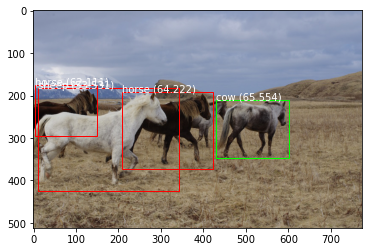

In [293]:
ytinyhat = combined_model.predict(image)
# print(f"ytinyhat shape : {ytinyhat.shape}")
draw_preds_bbs(photo_filename, ytinyhat)

In [285]:
ytinyhat

[array([[0.12830225, 0.7010668 , 0.04750067, 0.14268741],
        [0.13684775, 0.7318688 , 0.03739589, 0.12951843],
        [0.13834047, 0.7590185 , 0.03642595, 0.13016835],
        [0.13929397, 0.78531307, 0.03532016, 0.12772787],
        [0.13854097, 0.81120837, 0.03833324, 0.12931271],
        [0.14043169, 0.83768725, 0.03771913, 0.12587376],
        [0.14077187, 0.8588889 , 0.03933293, 0.12621692],
        [0.13651502, 0.8877397 , 0.05135405, 0.12345123],
        [0.6265495 , 0.8649261 , 0.07484937, 0.2531377 ],
        [0.8955328 , 0.2952927 , 0.33335617, 0.09718728],
        [0.90203345, 0.6251611 , 0.05398452, 0.06494099],
        [0.9052144 , 0.6294904 , 0.04726946, 0.06484264],
        [0.8980232 , 0.2788366 , 0.36405653, 0.10742968],
        [0.45645693, 0.04666999, 0.50566596, 0.41309497],
        [0.46541125, 0.11348805, 0.46116683, 0.39931566],
        [0.4630719 , 0.10815257, 0.48097694, 0.47765222],
        [0.61580336, 0.8665833 , 0.0727362 , 0.27243173],
        [0.611

In [345]:
combined_model.save('decoded_yolo.h5')

# convert to corem l

In [342]:
from PIL import Image
def load_local_and_scale_image(image_path, shape):
    image = Image.open(image_path)
    return image.resize(shape)

In [343]:
import coremltools as ct

In [346]:
coreml_converted_yolo = ct.convert('decoded_yolo.h5', inputs=[ct.ImageType(scale=1 / 255.0)], source= 'tensorflow')

ValueError: Unknown layer: NMSLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [31]:
coreml_converted_yolo.save('decoded_yolo.mlmodel')

In [21]:
coreml_converted_yolo = ct.models.MLModel('decoded_yolo.mlmodel')

In [22]:
print(coreml_converted_yolo)

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
      imageSizeRange {
        widthRange {
          lowerBound: 608
          upperBound: 608
        }
        heightRange {
          lowerBound: 608
          upperBound: 608
        }
      }
    }
  }
}
output {
  name: "Identity"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
output {
  name: "Identity_1"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
output {
  name: "Identity_2"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.8.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "5.2.0"
  }
}



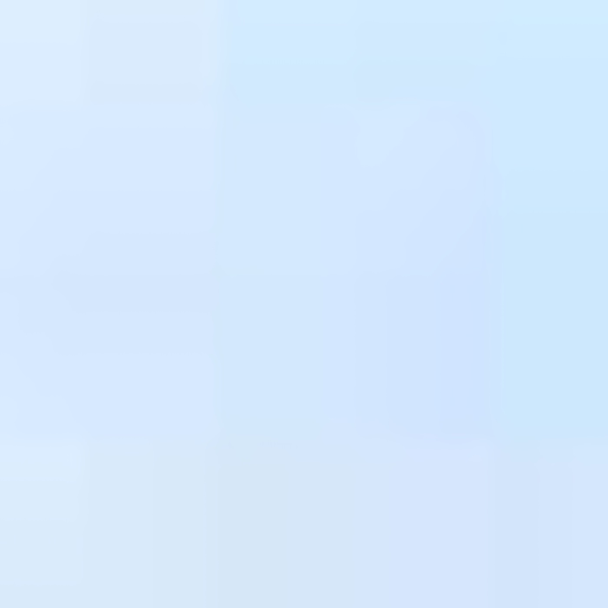

In [35]:
test_image = load_local_and_scale_image(photo_filename, (608, 608)) 
test_image

In [ ]:
preds_pipeline = coreml_converted_yolo.predict(data={'input_1': test_image})

(9, 4)
(9,)
start drawing boxes


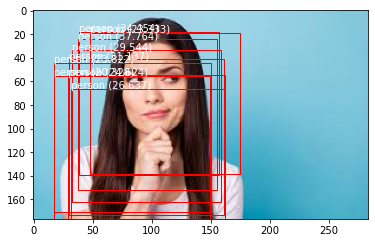

In [52]:
draw_preds_bbs(
    photo_filename, 
    [
        preds_pipeline['Identity'],
        preds_pipeline['Identity_1'],
        preds_pipeline['Identity_2'],
    ],
    is_coreml=True
)